In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

In [2]:
data_path = r"/Users/pranavi/Downloads/Data Science/Garbage Data/Garbage classification/Garbage classification"

In [3]:
img_size = 120

In [4]:
img_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

In [5]:
img_data = ImageFolder(data_path, transform=img_transform)

In [6]:
img_data.class_to_idx

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [7]:
len(img_data)

2527

In [8]:
train_data, val_data, test_data = random_split(img_data, [1900, 527, 100])

In [9]:
len(train_data)

1900

In [10]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [11]:
for img, labels in train_loader:
    print(img.shape, labels.shape)
    break

torch.Size([32, 3, 120, 120]) torch.Size([32])


In [12]:
def show_img_batch(data):
    for images, labels in data:
        plt.figure(figsize=(20,10))
        plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
        plt.show()
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


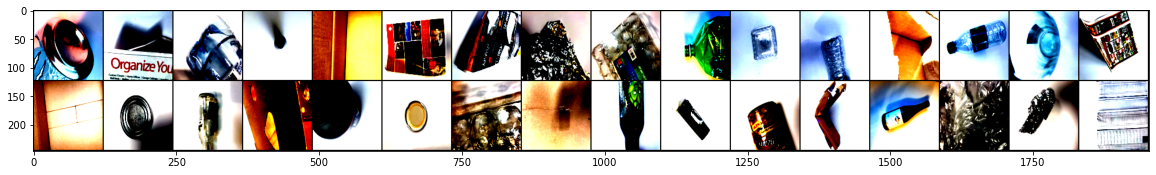

In [13]:
show_img_batch(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


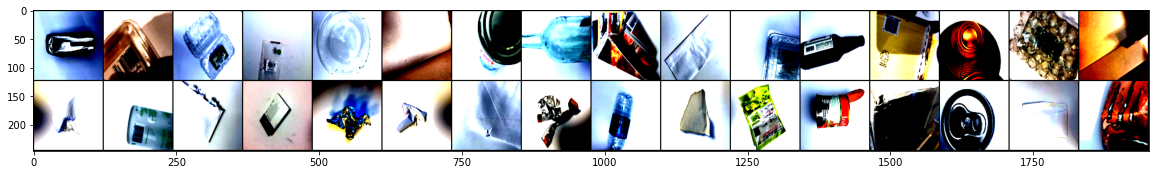

In [14]:
show_img_batch(val_loader)

In [36]:
class CNN(nn.Module):
    def __init__(self, kernel_size=3, out_channels1=64, out_channels2=128, out_channels3=256, out_channels4=352, 
                 out_channels5 = 512):
        super(CNN, self).__init__()
        
        self.features = nn.Sequential(
                        nn.Conv2d(in_channels=3, out_channels=out_channels1, kernel_size=kernel_size), #120-2=118
                        nn.ReLU(),
                        nn.MaxPool2d(2),#59
                        nn.Conv2d(in_channels= out_channels1, out_channels=out_channels2, kernel_size=kernel_size),
                        nn.ReLU(), #59-2=57
                        nn.MaxPool2d(2), #28
                        nn.Conv2d(in_channels=out_channels2, out_channels=out_channels3, kernel_size=kernel_size),
                        nn.ReLU(), #26
                        nn.MaxPool2d(2), #13
                        nn.Conv2d(in_channels=out_channels3, out_channels=out_channels4, kernel_size=kernel_size),
                        nn.ReLU(), #11
                        nn.MaxPool2d(2), #5
                        nn.Conv2d(in_channels=out_channels4, out_channels=out_channels5, kernel_size=kernel_size),
                        nn.ReLU(), #3
                        nn.MaxPool2d(2))#1
        
        self.classifier = nn.Sequential(
                          nn.Linear(512, 256),
                          nn.ReLU(),
                          nn.Dropout(0.1),
                          nn.Linear(256,128),
                          nn.ReLU(),
                          nn.Dropout(0.1),
                          nn.Linear(128,6))
            
    def forward(self,x):
            
            x = self.features(x)
            x = x.view(-1, 512)
            x = self.classifier(x)
            
            return x

In [37]:
model = CNN()
print(model.parameters)

<bound method Module.parameters of CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 352, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(352, 512, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
def CNN_train(loss_fn, optimizer):
    
    epochs = 20
    
    training_loss = []
    training_acc = []
    testing_loss = []
    testing_acc = []
    
    for epoch in range(epochs):
        
        train_acc = 0.0
        train_loss = 0.0
        
        model.train()
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            
            loss.backward()
            optimizer.step()
            
            predictions = torch.argmax(output,1)
            
            train_acc += (predictions==labels).sum().item()
            train_loss += loss.item()
            
        training_acc.append(train_acc/len(train_data))
        training_loss.append(train_loss/len(train_loader))
        
        model.eval()
        
        test_acc = 0.0
        test_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                output = model(images)
                loss = loss_fn(output, labels)
                
                predictions = torch.argmax(output,1)
                
                test_acc += (predictions==labels).sum().item()
                test_loss += loss.item()
                
            testing_acc.append(test_acc/len(val_data))
            testing_loss.append(test_loss/len(val_loader))
            
        print("Epochs:{},Training Accuracy:{:.2f},Training Loss:{:.2f},Validation Accuracy:{:.2f},Validation Loss:{:.2f}.".
             format(epoch+1, train_acc/len(train_data), train_loss/len(train_loader), test_acc/len(val_data),
                   test_loss/len(val_loader)))
        
    plt.title("Accuracy Vs Epohcs")
    plt.plot(range(epochs), training_acc, label="Training Accuracy")
    plt.plot(range(epochs), testing_acc, label="Validation Accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    
    plt.title("Loss Vs Epochs")
    plt.plot(range(epochs), testing_loss, label="Validation Loss")
    plt.plot(range(epochs), training_loss, label = "Training Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    

Epochs:1,Training Accuracy:0.23,Training Loss:1.71,Validation Accuracy:0.24,Validation Loss:1.68.
Epochs:2,Training Accuracy:0.29,Training Loss:1.63,Validation Accuracy:0.31,Validation Loss:1.68.
Epochs:3,Training Accuracy:0.35,Training Loss:1.55,Validation Accuracy:0.41,Validation Loss:1.48.
Epochs:4,Training Accuracy:0.43,Training Loss:1.41,Validation Accuracy:0.48,Validation Loss:1.38.
Epochs:5,Training Accuracy:0.45,Training Loss:1.40,Validation Accuracy:0.47,Validation Loss:1.35.
Epochs:6,Training Accuracy:0.48,Training Loss:1.34,Validation Accuracy:0.54,Validation Loss:1.28.
Epochs:7,Training Accuracy:0.53,Training Loss:1.24,Validation Accuracy:0.56,Validation Loss:1.18.
Epochs:8,Training Accuracy:0.53,Training Loss:1.20,Validation Accuracy:0.55,Validation Loss:1.18.
Epochs:9,Training Accuracy:0.56,Training Loss:1.16,Validation Accuracy:0.56,Validation Loss:1.16.
Epochs:10,Training Accuracy:0.58,Training Loss:1.10,Validation Accuracy:0.60,Validation Loss:1.12.
Epochs:11,Training 

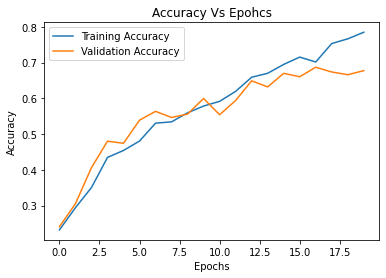

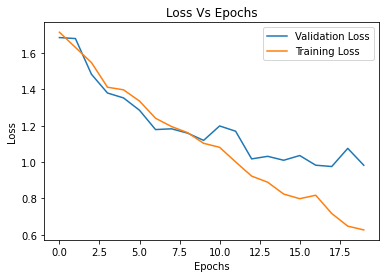

In [19]:
CNN_train(loss_fn, optimizer)

In [40]:
def predict_img(img,model):
    x = img.unsqueeze(0)
    y = model(x)
    
    prediction = torch.argmax(y, dim=1)
    return img_data.classes[prediction]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label plastic Predicted Label plastic


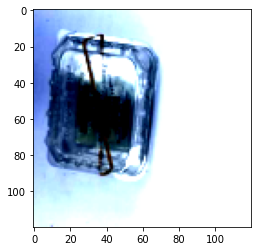

In [43]:
img, label = test_data[10]
plt.imshow(img.permute(1,2,0))
print("Actual Label", img_data.classes[label], "Predicted Label", predict_img(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label metal Predicted Label plastic


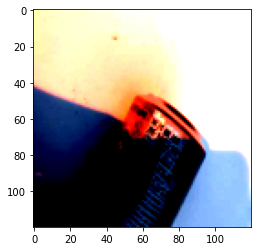

In [51]:
img, label = test_data[28]
plt.imshow(img.permute(1,2,0))
print("Actual Label", img_data.classes[label], "Predicted Label", predict_img(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label plastic Predicted Label plastic


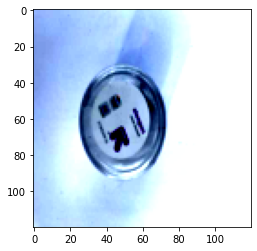

In [54]:
img, label = test_data[86]
plt.imshow(img.permute(1,2,0))
print("Actual Label", img_data.classes[label], "Predicted Label", predict_img(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label glass Predicted Label plastic


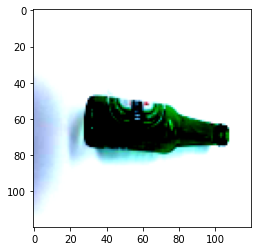

In [58]:
img, label = test_data[73]
plt.imshow(img.permute(1,2,0))
print("Actual Label", img_data.classes[label], "Predicted Label", predict_img(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Label cardboard Predicted Label cardboard


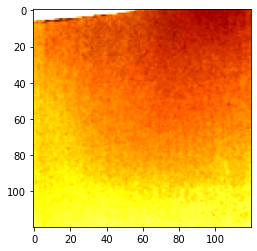

In [59]:
img, label = test_data[64]
plt.imshow(img.permute(1,2,0))
print("Actual Label", img_data.classes[label], "Predicted Label", predict_img(img, model))